In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path("../../../").resolve()))
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
import pandas as pd
import pickle as pkl
from ball_model import EXPERIMENT_DIR
from ball_model.data import get_data, iter_traj
from tqdm.notebook import tqdm
import re
from joblib import Parallel, delayed

from ball_model.utils.plotting import MplUtils

MplUtils.set_style(plt, "thesis")

In [2]:
def filter_dataframe(df, method_id, train_aug, use_side_info, dataset_name):
    # method_id: ekf, rssm, tvae
    # train_aug: True, False
    # use_side_info: True, False
    train_dataset = "lp7aug" if train_aug else "lp7"
    if method_id == "ekf":
        side_info_string = "sialways" if use_side_info else "sinever"
        run_stem = f"model_ekf_g_{train_dataset}_{side_info_string}"
    else:
        raise ValueError

    df_filt = df[df["run_stem"] == run_stem]
    df_filt = df_filt[df_filt["use_side_info"] == use_side_info]

    # dataset
    df_filt = df_filt[df_filt["traj_split"] == "test"]
    if dataset_name == "default":
        df_filt = df_filt[df_filt["eval_group"] == "lp7"]
    elif dataset_name == "unseen":
        df_filt = df_filt[df_filt["eval_group"] == "lp9"]
    return df_filt


def convert_run_name(run_name):
    # convert run_name 20221121_ekf_g_lp7aug_c50_mslossFalse_sialways_imstateFalse_rotaugnone_s1 
    # to model_ekf_g_lp7aug_sialways_s1   
    pattern = "20221121_ekf_g_(.+)_c50_mslossFalse_si(.+)_imstateFalse_rotaugnone_s(\d+)"
    prog = re.compile(pattern)
    match = prog.match(run_name)
    if match is not None:
        new_run_name = f"model_ekf_g_{match.group(1)}_si{match.group(2)}_s{match.group(3)}"
        return new_run_name
    else:
        return run_name
    
def load_df(eval_file_list, drop_traj):
    df_list = []
    for eval_file in tqdm(eval_file_list):
        single_df = load_single_df(eval_file, drop_traj)
        df_list.append(single_df)
    df = pd.concat(df_list)
    
    df["run_name"] = df["run_name"].apply(convert_run_name)
    
    df["run_stem"] = df["run_name"].apply(lambda x: "_".join(x.split("_")[:-1]))
    df["traj_group"] = df["traj_fullname"].apply(lambda x: x.split("%")[0])
    df["eval_group"] = df["traj_group"]
    return df


def load_single_df(filepath, drop_traj):
    df = pd.read_pickle(filepath)

    if "state_mean" in df.columns and drop_traj:
        df.drop(
            [
                "state_mean",
                "state_cov",
                "filter_type",
                "maxabserr",
                "euclerr",
            ],
            axis=1,
            inplace=True,
        )
    return df


def list_eval_files_by_pattern(dir_pattern, file_pattern):
    dir_re = re.compile(dir_pattern)

    eval_file_list = []
    for subdir in tqdm(list(EXPERIMENT_DIR.iterdir())):
        if not subdir.is_dir():
            continue

        if subdir.name.startswith("_"):
            continue

        seed = int(subdir.name.split("_")[-1][1:])
        if seed not in list(range(1, 11)):
            continue

        if not dir_re.match(subdir.name):
            continue

        file_pattern_parsed = file_pattern.format(step=10000)
        file_re = re.compile(file_pattern_parsed)

        if not subdir.joinpath("filter_evaluations").is_dir():
            print(f"{subdir} has no evals")
            continue

        for filter_file in subdir.joinpath("filter_evaluations").iterdir():
            if not file_re.match(filter_file.name):
                continue
            eval_file_list.append(filter_file)
    return eval_file_list

In [3]:
dir_pattern = ".+_lp7(aug)?_.+"  # trained on lp7(aug), evaluated on lp7/lp9 with predhz 1 sec
file_pattern = "filter_evaluation_step{step}_lp[79]_1\.0_si.+\.pkl"
eval_files_onesec = list_eval_files_by_pattern(dir_pattern, file_pattern)
df_onesec = load_df(eval_files_onesec, drop_traj=True)

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

In [4]:
dir_pattern = ".+ekf.+lp7aug.+"  # trained on lp7aug, evaluated on lp9 with predhz 1 sec, with sideinfo, keep full trajs.
file_pattern = "filter_evaluation_step{step}_lp[79]_1.0_siTrue.pkl"
eval_files_full = list_eval_files_by_pattern(dir_pattern, file_pattern)
df_full = load_df(eval_files_full, drop_traj=False)

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [5]:
df_full["run_name"].unique()

array(['model_ekf_g_lp7aug_sialways_s1',
       'model_ekf_g_lp7aug_sialways_s10',
       'model_ekf_g_lp7aug_sialways_s2', 'model_ekf_g_lp7aug_sialways_s3',
       'model_ekf_g_lp7aug_sialways_s4', 'model_ekf_g_lp7aug_sialways_s5',
       'model_ekf_g_lp7aug_sialways_s6', 'model_ekf_g_lp7aug_sialways_s7',
       'model_ekf_g_lp7aug_sialways_s8', 'model_ekf_g_lp7aug_sialways_s9',
       'model_ekf_g_lp7aug_sinever_s1', 'model_ekf_g_lp7aug_sinever_s10',
       'model_ekf_g_lp7aug_sinever_s2', 'model_ekf_g_lp7aug_sinever_s3',
       'model_ekf_g_lp7aug_sinever_s4', 'model_ekf_g_lp7aug_sinever_s5',
       'model_ekf_g_lp7aug_sinever_s6', 'model_ekf_g_lp7aug_sinever_s7',
       'model_ekf_g_lp7aug_sinever_s8', 'model_ekf_g_lp7aug_sinever_s9'],
      dtype=object)

In [6]:
df_onesec["run_name"].unique()

array(['model_ekf_g_lp7aug_sialways_s1',
       'model_ekf_g_lp7aug_sialways_s10',
       'model_ekf_g_lp7aug_sialways_s2', 'model_ekf_g_lp7aug_sialways_s3',
       'model_ekf_g_lp7aug_sialways_s4', 'model_ekf_g_lp7aug_sialways_s5',
       'model_ekf_g_lp7aug_sialways_s6', 'model_ekf_g_lp7aug_sialways_s7',
       'model_ekf_g_lp7aug_sialways_s8', 'model_ekf_g_lp7aug_sialways_s9',
       'model_ekf_g_lp7aug_sinever_s1', 'model_ekf_g_lp7aug_sinever_s10',
       'model_ekf_g_lp7aug_sinever_s2', 'model_ekf_g_lp7aug_sinever_s3',
       'model_ekf_g_lp7aug_sinever_s4', 'model_ekf_g_lp7aug_sinever_s5',
       'model_ekf_g_lp7aug_sinever_s6', 'model_ekf_g_lp7aug_sinever_s7',
       'model_ekf_g_lp7aug_sinever_s8', 'model_ekf_g_lp7aug_sinever_s9',
       'model_ekf_g_lp7_sialways_s1', 'model_ekf_g_lp7_sialways_s10',
       'model_ekf_g_lp7_sialways_s2', 'model_ekf_g_lp7_sialways_s3',
       'model_ekf_g_lp7_sialways_s4', 'model_ekf_g_lp7_sialways_s5',
       'model_ekf_g_lp7_sialways_s6', 'mode

In [7]:
# Compute mean over all trajectories
df_onesec_mean = (
    df_onesec.groupby(
        [
            "run_stem",
            "run_name",
            "traj_split",
            "min_pred_length_sec",
            "use_side_info",
            "eval_group",
        ]
    )[["run_stem", "maxeuclerr_last5"]]
    .mean()
    .reset_index()
)

In [8]:
METHODS = {
    # method_id, train_aug
    "EKF": ("ekf", True),
    "EKF (w/o aug.)": ("ekf", False),
}


def build_ablation_df():
    ablation_df_list = []
    df_in = df_onesec[df_onesec["min_pred_length_sec"] == 1.0]

    for eval_dataset_name, eval_dataset_abbr in zip(
        ["default", "unseen"], ["def.", "uns."]
    ):
        for use_side_info in [True, False]:
            for method_name, (method_id, train_aug) in METHODS.items():

                if method_name == "TVAE" and use_side_info:
                    continue

                df_eval = filter_dataframe(
                    df_in, method_id, train_aug, use_side_info, eval_dataset_name
                )
                df_eval = df_eval.copy()

                df_eval["ablation"] = method_name
                df_eval["use_side_info"] = use_side_info
                df_eval["eval_group_name"] = eval_dataset_abbr

                ablation_df_list.append(df_eval)

    ablation_df = pd.concat(ablation_df_list)
    return ablation_df[
        ["eval_group_name", "ablation", "use_side_info", "maxeuclerr_last5"]
    ]


ablation_df = build_ablation_df()

In [9]:
ablation_df

,eval_group_name,ablation,use_side_info,maxeuclerr_last5
0,def.,EKF,True,0.048676
2,def.,EKF,True,0.047846
3,def.,EKF,True,0.053301
4,def.,EKF,True,0.048622
5,def.,EKF,True,0.063945
...,...,...,...,...
145,uns.,EKF (w/o aug.),False,0.444124
146,uns.,EKF (w/o aug.),False,0.487310
147,uns.,EKF (w/o aug.),False,0.787823
148,uns.,EKF (w/o aug.),False,0.699970


In [10]:
def make_boxplot(
    ablation_whitelist, fig_width, yoffset, yspacing, has_preamble, symlog
):
    fig, ax = plt.subplots(figsize=(fig_width, 1.75))
    boxplot_by = ["ablation", "eval_group_name", "use_side_info"]
    filtered_df = ablation_df[ablation_df["ablation"].isin(ablation_whitelist)]
    label_df = filtered_df[boxplot_by].drop_duplicates().sort_values(by=boxplot_by)

    flierprops = dict(marker="x", markersize=2, linestyle="none")
    filtered_df.boxplot(by=boxplot_by, rot=90, ax=ax, flierprops=flierprops)

    levels = {k: [] for k in range(len(boxplot_by))}
    # levels: dictionary for each level, indicating start and end of labels (inclusive), ie.
    #
    # 0: [("EKF", 0, 3), ("EKF (nodata)", 4, 7)], ...
    # 1: [("train_pos", 0, 1), ("unseen_pos", 1, 2), ...]
    #
    for row_idx, row in enumerate(label_df.iterrows()):
        for level in levels.keys():
            text = str(row[1][level])
            if (
                level == max(levels.keys())
                or len(levels[level]) == 0
                or levels[level][-1][0] != text
            ):
                levels[level].append([text, row_idx, row_idx])
            elif levels[level][-1][0] == text:
                # update last seen
                levels[level][-1][2] = row_idx
    print(levels)

    level_labels = ["Method", "Launcher pos.", "W/ launch info"]
    for level in levels.keys():
        y = -(2 - level) * yspacing - yoffset
        for text, start_x, end_x in levels[level]:
            if level == 2:
                text = {"True": "yes", "False": "no"}[text]
            if level == 0:
                text = r"\textbf{" + text + "}"
            ax.text(
                (start_x + end_x + 2) / 2,
                y,
                text,
                horizontalalignment="center",
                verticalalignment="center",
            )

        if has_preamble:
            ax.text(
                0.3,
                y,
                level_labels[level],
                horizontalalignment="right",
                verticalalignment="center",
            )

    ax.set_xticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("Pred. error\n 1s pred. [m]")
    ax.set_title("")
    if symlog:
        ax.set_yscale("symlog", linthresh=1)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 2, 5])
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1, 2, 5])
        ax.set_ylim(-0.1, 10)
    # ax.set_ylim(0, 2)
    fig.suptitle("")

In [11]:
def get_width(fraction=1, ncols=1):
    figwidth = 1.05 * 5.89
    spacing_mm = 5
    spacing_in = spacing_mm / 25.4
    figwidth = fraction * (figwidth - (ncols - 1) * spacing_in)
    return figwidth

{0: [['EKF', 0, 3], ['EKF (w/o aug.)', 4, 7]], 1: [['def.', 0, 1], ['uns.', 2, 3], ['def.', 4, 5], ['uns.', 6, 7]], 2: [['False', 0, 0], ['True', 1, 1], ['False', 2, 2], ['True', 3, 3], ['False', 4, 4], ['True', 5, 5], ['False', 6, 6], ['True', 7, 7]]}


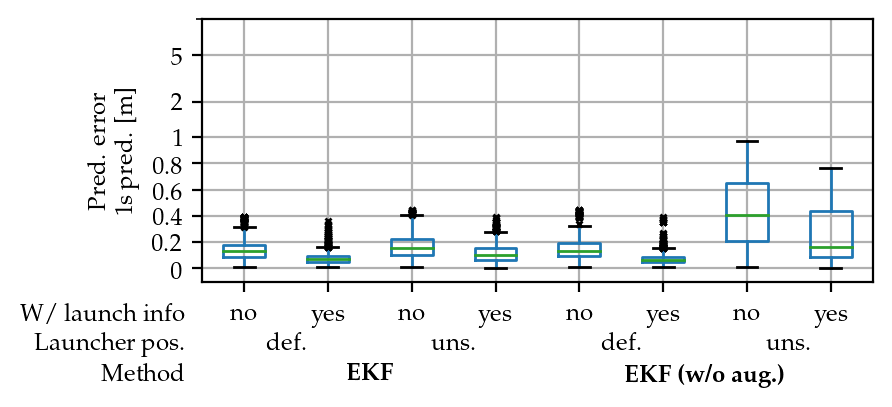

In [12]:
make_boxplot(
    ["EKF", "EKF (w/o aug.)"], get_width(0.7, 2), 0.35, 0.23, True, True
)
plt.savefig("graphics/results_ekf_vrnn.png", bbox_inches="tight", pad_inches=0)

{0: [['EKF', 0, 3]], 1: [['def.', 0, 1], ['uns.', 2, 3]], 2: [['False', 0, 0], ['True', 1, 1], ['False', 2, 2], ['True', 3, 3]]}


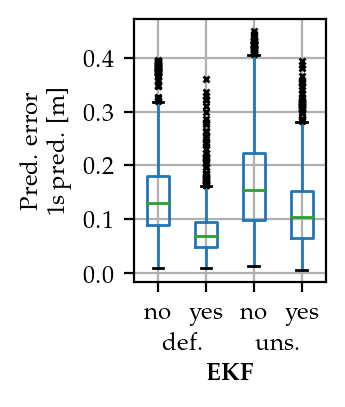

In [13]:
make_boxplot(["EKF"], get_width(0.2, 2), 0.075, 0.057, False, False)
plt.savefig("graphics/results_ekf_detail.png", bbox_inches="tight", pad_inches=0)

## Plot best and worst trajectories from 'unseen' dataset

In [14]:
def plot_traj(traj_fullname, run_name, fig, ax_arr, title_prefix):
    eval_group = traj_fullname.split("%")[0]
    df_filt = pd.read_pickle(
        EXPERIMENT_DIR.joinpath(
            run_name,
            "filter_evaluations",
            f"filter_evaluation_step10000_{eval_group}_1.0_siTrue.pkl",
        )
    )
    df_filt["run_name"] = df_filt["run_name"].apply(convert_run_name)

    gt_traj = get_data(traj_fullname)
    filt_pred_item = df_filt[
        (df_filt["traj_fullname"] == traj_fullname) & (df_filt["run_name"] == run_name)
    ].iloc[0]
    err = filt_pred_item["maxeuclerr_last5"]
    filt_pred_mean = filt_pred_item["state_mean"]
    n_filt = filt_pred_item["filter_length"]
    print(filt_pred_item.keys())

    from ball_model.data import IDEAL_TABLE

    half_length_of_table = 1.37
    half_width_of_table = 0.7625

    ax_arr[0].scatter(
        gt_traj.timestamps[::10],
        gt_traj.positions[:, 2][::10],
        s=0.6,
        alpha=1,
        zorder=-10,
    )
    ax_arr[0].plot([], [])
    ax_arr[0].plot(
        gt_traj.timestamps[:n_filt], filt_pred_mean[:n_filt, 2], linewidth=0.7
    )
    ax_arr[0].plot(
        gt_traj.timestamps[n_filt:], filt_pred_mean[n_filt:, 2], linewidth=0.7
    )
    ax_arr[0].axhline(y=IDEAL_TABLE[2], linestyle="--", color="gray", alpha=0.6)
    ax_arr[0].set_xlim([-0.1, 1.3])
    ax_arr[0].set_ylim([-0.5, 0.7])
    ax_arr[0].set_xlabel("time [s]")
    ax_arr[0].set_ylabel("z [m]")

    ax_arr[1].scatter(
        gt_traj.positions[:, 0][::10],
        gt_traj.positions[:, 1][::10],
        s=0.6,
        alpha=1,
        zorder=-10,
    )
    ax_arr[1].plot([], [])
    ax_arr[1].plot(
        filt_pred_mean[:n_filt, 0], filt_pred_mean[:n_filt, 1], linewidth=0.7
    )
    ax_arr[1].plot(
        filt_pred_mean[n_filt:, 0], filt_pred_mean[n_filt:, 1], linewidth=0.7
    )
    table_x_range = [
        IDEAL_TABLE[0] - half_width_of_table,
        IDEAL_TABLE[0] + half_width_of_table,
    ]
    table_y_range = [
        IDEAL_TABLE[1] - half_length_of_table,
        IDEAL_TABLE[1] + half_length_of_table,
    ]
    ax_arr[1].fill_between(
        np.array(
            [IDEAL_TABLE[0] - half_width_of_table, IDEAL_TABLE[0] + half_width_of_table]
        ),
        np.array(
            [
                IDEAL_TABLE[1] - half_length_of_table,
                IDEAL_TABLE[1] - half_length_of_table,
            ]
        ),
        np.array(
            [
                IDEAL_TABLE[1] + half_length_of_table,
                IDEAL_TABLE[1] + half_length_of_table,
            ]
        ),
        color="gray",
        alpha=0.2,
    )
    ax_arr[1].set_xlim(np.array(table_x_range) + np.array([-0.5, 0.5]))
    ax_arr[1].set_ylim(np.array(table_y_range) + np.array([-0.5, 0.5]))
    ax_arr[1].invert_yaxis()
    ax_arr[1].set_xlabel("x [m]")
    ax_arr[1].set_ylabel("y [m]")
    ax_arr[1].set_xticks([-0.8, 1.1])
    ax_arr[1].invert_xaxis()

    fig.suptitle(f"{title_prefix}, error = {err:.3f}m")

In [15]:
pd.set_option('max_colwidth', 120)

In [16]:
# Plot worst, q10, median (test) trajectories
df_full_onesec = df_full[df_full["min_pred_length_sec"] == 1.0]
df_eval = filter_dataframe(
    df_full_onesec,
    method_id="ekf",
    train_aug=True,
    use_side_info=True,
    dataset_name="unseen",
)
sorted_df = df_eval.sort_values(by="maxeuclerr_last5")

In [17]:
# worst
worst_id, worst_run_name = sorted_df.iloc[-1][["traj_fullname", "run_name"]]
# q90
q90_id, q90_run_name = sorted_df.iloc[int(0.9 * len(sorted_df))][
    ["traj_fullname", "run_name"]
]
# median
median_id, median_run_name = sorted_df.iloc[int(0.5 * len(sorted_df))][
    ["traj_fullname", "run_name"]
]
# best
best_id, best_run_name = sorted_df.iloc[0][["traj_fullname", "run_name"]]

print(worst_id, worst_run_name)
print(q90_id, q90_run_name)
print(median_id, median_run_name)
print(best_id, best_run_name)

lp9%9534 model_ekf_g_lp7aug_sialways_s10
lp9%9551 model_ekf_g_lp7aug_sialways_s3
lp9%9240 model_ekf_g_lp7aug_sialways_s1
lp9%9338 model_ekf_g_lp7aug_sialways_s1


Index(['state_mean', 'state_cov', 'filter_type', 'maxabserr', 'euclerr',
       'run_name', 'checkpoint_step', 'traj_fullname', 'traj_split',
       'traj_length', 'filter_length', 'min_pred_length_sec', 'use_side_info',
       'maxabserr_last5', 'maxeuclerr_last5'],
      dtype='object')
Index(['state_mean', 'state_cov', 'filter_type', 'maxabserr', 'euclerr',
       'run_name', 'checkpoint_step', 'traj_fullname', 'traj_split',
       'traj_length', 'filter_length', 'min_pred_length_sec', 'use_side_info',
       'maxabserr_last5', 'maxeuclerr_last5'],
      dtype='object')
Index(['state_mean', 'state_cov', 'filter_type', 'maxabserr', 'euclerr',
       'run_name', 'checkpoint_step', 'traj_fullname', 'traj_split',
       'traj_length', 'filter_length', 'min_pred_length_sec', 'use_side_info',
       'maxabserr_last5', 'maxeuclerr_last5'],
      dtype='object')


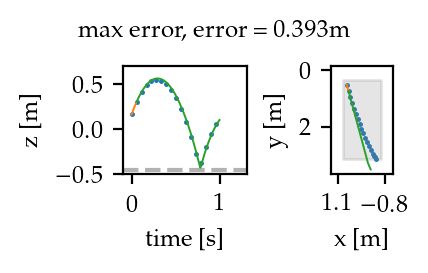

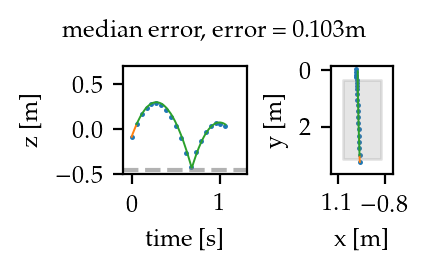

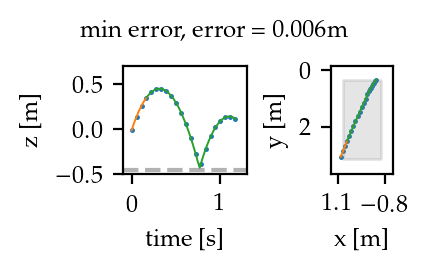

In [18]:
fig, ax_arr = plt.subplots(
    nrows=1,
    ncols=2,
    constrained_layout=True,
    gridspec_kw={"width_ratios": [2, 1]},
    figsize=(get_width(0.35, 3), 1.25),
)
plot_traj(worst_id, worst_run_name, fig, ax_arr, "max error")
plt.savefig("graphics/lp9_ekf_variants_err_max.png", bbox_inches="tight", pad_inches=0)

fig, ax_arr = plt.subplots(
    nrows=1,
    ncols=2,
    constrained_layout=True,
    gridspec_kw={"width_ratios": [2, 1]},
    figsize=(get_width(0.35, 3), 1.25),
)
plot_traj(median_id, median_run_name, fig, ax_arr, "median error")
plt.savefig(
    "graphics/lp9_ekf_variants_err_median.png", bbox_inches="tight", pad_inches=0
)


fig, ax_arr = plt.subplots(
    nrows=1,
    ncols=2,
    constrained_layout=True,
    gridspec_kw={"width_ratios": [2, 1]},
    figsize=(get_width(0.35, 3), 1.25),
)
plot_traj(best_id, best_run_name, fig, ax_arr, "min error")
plt.savefig("graphics/lp9_ekf_variants_err_min.png", bbox_inches="tight", pad_inches=0)

## Compare different min_pred_lengths (EKF/RSSM/TVAE) on unseen dataset

In [19]:
dir_pattern = ".+lp7aug.+"  # trained on lp7aug
file_pattern = "filter_evaluation_step{step}_lp9_\d\.\d_si.+\.pkl"
eval_files_predhz = list_eval_files_by_pattern(dir_pattern, file_pattern)
df_predhz = load_df(eval_files_predhz, drop_traj=True)

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [20]:
METHODS_EKF = {
    # method_id, train_aug, use_side_info
    "EKF w/ li.": ("ekf", True, True),
    "EKF w/o li.": ("ekf", True, False),
}

In [21]:
def plot_predhz(ax, df_predhz, method_name, method_id, train_aug, use_side_info):
    df_eval = filter_dataframe(
        df_predhz,
        method_id=method_id,
        train_aug=train_aug,
        use_side_info=use_side_info,
        dataset_name="unseen",
    )
    print(method_name, method_id, train_aug, use_side_info, len(df_eval))

    df_group = df_eval.groupby(["min_pred_length_sec"])["maxeuclerr_last5"]
    agg_np = {}
    for agg in ["median", "q10", "q90"]:
        agg_fcn = {
            "median": "median",
            "q10": lambda x: x.quantile(0.1),
            "q90": lambda x: x.quantile(0.9),
        }
        agg_np[agg] = (
            df_group.agg(agg_fcn[agg])
            .reset_index()[["min_pred_length_sec", "maxeuclerr_last5"]]
            .to_numpy()
        )
    ax.plot(agg_np["median"][:, 0], agg_np["median"][:, 1], label=method_name)
    ax.fill_between(
        agg_np["median"][:, 0], agg_np["q10"][:, 1], agg_np["q90"][:, 1], alpha=0.2
    )

EKF w/ li. ekf True True 15000
EKF w/o li. ekf True False 15000


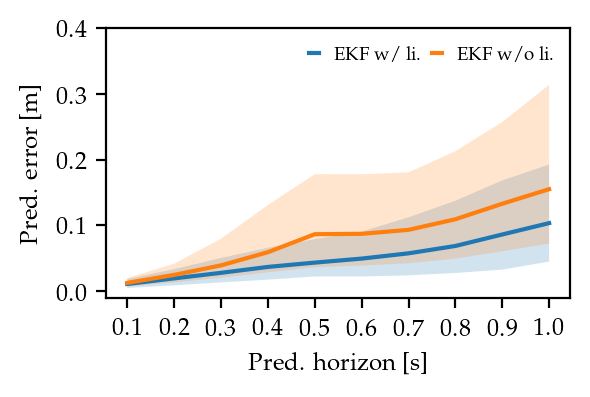

In [22]:
fig, ax = plt.subplots(figsize=(get_width(0.5, 2), 1.75), ncols=1)
for method_name, (method_id, train_aug, use_side_info) in METHODS_EKF.items():
    plot_predhz(ax, df_predhz, method_name, method_id, train_aug, use_side_info)
ax.set_ylabel("Pred. error [m]")
ax.set_xlabel("Pred. horizon [s]")
ax.set_xticks([x / 10 for x in range(1, 11)])
ax.set_ylim(-0.01, 0.4)
ax.legend(
    ncol=2,
    handlelength=0.5,
    fancybox=False,
    framealpha=0,
    columnspacing=0.5,
    bbox_to_anchor=(1.005, 1),
    fontsize=7,
)
plt.savefig(
    "graphics/pred_performance_horizon_ekf.png", bbox_inches="tight", pad_inches=0
)